# Assignment 1: Computational Finance

In [ ]:
# Imports
import datetime
import math as m
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import math


In [ ]:
ticker = "AAPL"
start_date = "2010-01-01"
end_date = datetime.datetime.now().strftime("%Y-%m-%d")

data = yf.download(ticker, start = start_date, end = end_date)

[*********************100%***********************]  1 of 1 completed


Historical Estimators

In [109]:
data.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2010-01-04,6.440332,6.455078,6.391279,6.422878,493729600
2010-01-05,6.451466,6.487879,6.417460,6.458087,601904800
2010-01-06,6.348847,6.477046,6.342226,6.451466,552160000
2010-01-07,6.337110,6.379844,6.291067,6.372320,477131200
2010-01-08,6.379241,6.379843,6.291368,6.328683,447610800


In [224]:
def natural_estimator_drift(data):
    # Make sure the index is datetime and sorted
    data = data.sort_index()
    try:
        close_prices = data[("Close", "AAPL")]
    except Exception:
        close_prices = data["Close"]
    dates = data.index

    N = len(data)
    drift_sum = 0

    for i in range(N - 1):
        try:
            date_diff_days = (dates[i + 1] - dates[i]).days
        except:
            date_diff_days = (dates[i+1] - dates[i])
        if date_diff_days == 0:
            continue  # Avoid division by zero
        try:
            price_now = close_prices[i]
            price_next = close_prices[i + 1]
        except:
            price_now = close_prices.iloc[i]
            price_next = close_prices.iloc[i + 1]
        kvocient = (price_next - price_now) / price_now
        drift_sum += kvocient / date_diff_days

    drift = drift_sum / (N - 1)
    return drift


def natural_estimator_volatility(data):
    # Make sure the index is datetime and sorted
    data = data.sort_index()
    try:
        close_prices = data[("Close", "AAPL")]
    except Exception:
        close_prices = data["Close"]
    dates = data.index

    N = len(data)
    natural_drift = natural_estimator_drift(data)

    vol_sum = 0

    for i in range(N - 1):
        try:
            date_diff_days = (dates[i + 1] - dates[i]).days
        except Exception:
            date_diff_days = (dates[i+1] - dates[i])
        if date_diff_days == 0:
            continue  # Avoid division by zero
        try:
            price_now = close_prices[i]
            price_next = close_prices[i + 1]
        except:
            price_now = close_prices.iloc[i]
            price_next = close_prices.iloc[i + 1]

        kvocient_price = (price_next - price_now) / price_now
        squared_term = (kvocient_price - date_diff_days * natural_drift) ** 2

        vol_sum += squared_term / date_diff_days

    volatility = vol_sum / (N - 1)
    return np.sqrt(volatility)


Added T (we believe in the formula, it was wrong)

In [171]:
def sigma_parkinson_estimator(_high, _low, _open, _close, T):
    return np.sqrt(
        1/(4*np.log(2)*T)*np.sum(np.log(_high/_low)**2)
        )

In [172]:
def sigma_garman_klass_estimator(_high, _low, _open, _close, T):
    return np.sqrt(
        (1/(2*T))*np.sum(np.log(_high/_low)**2) - 
        ((2*np.log(2)-1)/T) * np.sum((np.log(_close/_open))**2)
        )

In [173]:
T = len(data)
print(T)

3847


In [174]:
rollingT = 30
sigma_gk = [
    sigma_garman_klass_estimator(
        data.iloc[t:t+rollingT ]["High"].to_numpy(),
        data.iloc[t:t+rollingT ]["Low"].to_numpy(),
        data.iloc[t:t+rollingT ]["Open"].to_numpy(),
        data.iloc[t:t+rollingT ]["Close"].to_numpy(), 
        rollingT
    )
    for t in range(len(data) - rollingT + 1)
]

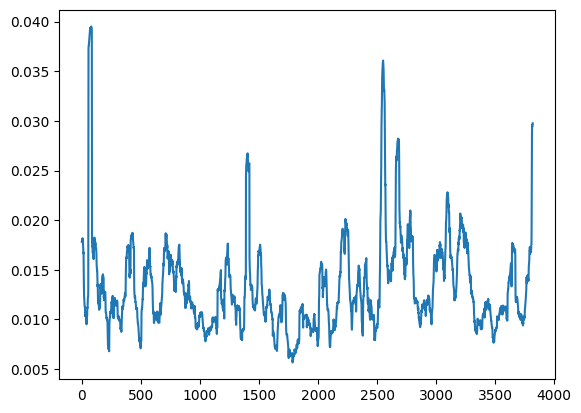

In [175]:
import matplotlib.pyplot as plt

plt.plot(sigma_gk)
plt.show()

In [176]:
sigma_p = [
    sigma_parkinson_estimator(
        data.iloc[t:t+rollingT]["High"].to_numpy(),
        data.iloc[t:t+rollingT]["Low"].to_numpy(),
        data.iloc[t:t+rollingT]["Open"].to_numpy(),
        data.iloc[t:t+rollingT]["Close"].to_numpy(),
        rollingT
    )
    for t in range(len(data) - rollingT + 1)
]

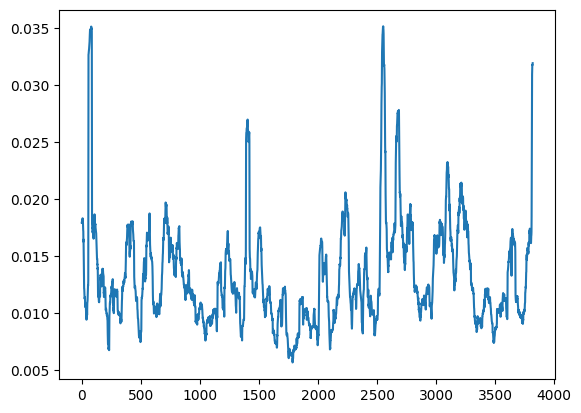

In [177]:
import matplotlib.pyplot as plt

plt.plot(sigma_p)
plt.show()

In [178]:
nat_sigma = [
    natural_estimator_volatility(
        data.iloc[t:t+rollingT]
    )
    for t in range(len(data) - rollingT + 1)
]

C:\Users\andre\AppData\Local\Temp\ipykernel_22920\23013233.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  price_now = close_prices[i]
C:\Users\andre\AppData\Local\Temp\ipykernel_22920\23013233.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  price_next = close_prices[i + 1]
C:\Users\andre\AppData\Local\Temp\ipykernel_22920\23013233.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  price_now = close_prices[i]
C:\Users\an

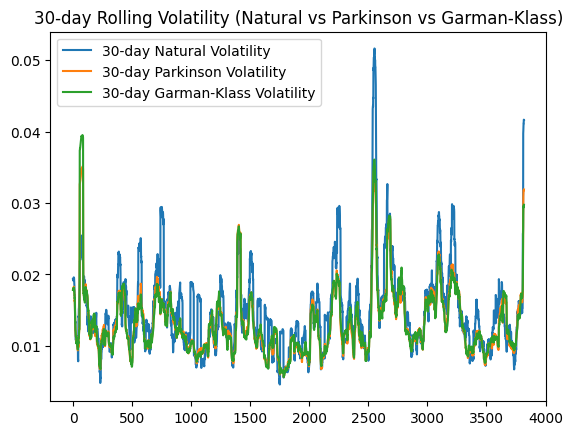

In [179]:

window = 30
plt.figure()
plt.plot(
    nat_sigma, 
    label=f"{window}-day Natural Volatility"
)
plt.plot(
    sigma_p, 
    label=f"{window}-day Parkinson Volatility"
)
plt.plot( 
    sigma_gk, 
    label=f"{window}-day Garman-Klass Volatility"
)
plt.title(f"{window}-day Rolling Volatility (Natural vs Parkinson vs Garman-Klass)")
plt.legend()
plt.show()

In [ ]:
import pandas as pd
from skfolio.datasets import load_sp500_dataset, load_sp500_implied_vol_dataset
from skfolio.preprocessing import prices_to_returns
prices = load_sp500_dataset()
implied_vol = load_sp500_implied_vol_dataset()
X = prices_to_returns(prices)
X = X.loc["2010":, [ticker]] # we keep AAPL only
X.tail()

,AAPL
Date,
2022-12-21,0.023811
2022-12-22,-0.023775
2022-12-23,-0.002799
2022-12-27,-0.013881
2022-12-28,-0.030682


In [ ]:
import yfinance as yf
import math 
spx_symbol = "^SPX"
today = "2025-04-18"
end_date = datetime.datetime.strptime(today, "%Y-%m-%d")
start_date = end_date - datetime.timedelta(days=365)

spx_data = yf.download(spx_symbol, start=start_date, end=end_date)
lastBusDay = spx_data.index[-1]
vix_data = yf.download("^VIX", start=lastBusDay, end = lastBusDay + datetime.timedelta(days=1))
S0 = float(spx_data["Close"].iloc[-1]) 
r = 0.02  #fixed

F0 = S0 * math.exp(r * 30 / 360)  # Assuming money market compounding
print(F0)


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed

5291.512036799481



C:\Users\andre\AppData\Local\Temp\ipykernel_22920\2472417141.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  S0 = float(spx_data["Close"].iloc[-1])


b) and c) We compute the estimated VIX and we compare it with the CBOE-quoted VIX

In [208]:
import yfinance as yf

import re

def get_dte30(nearest_friday=False):
    FRIDAY = 4
    DTE_30 = 30
    today = datetime.datetime.today().date()

    t = today + datetime.timedelta(days=DTE_30)
    if nearest_friday:
        inc = 1 if t.weekday() < FRIDAY else -1
        while t.weekday() != FRIDAY:
            t += datetime.timedelta(days=inc)
        return t.strftime("%Y-%m-%d")
    
    while t.weekday() > FRIDAY:
        t += datetime.timedelta(days=1)

    return t.strftime("%Y-%m-%d")
def set_time_to_expiry_column(option_chain):
    def extract_expiration_from_symbol(contract_symbol):
        match = re.search(r'(\d{6})', contract_symbol)
        if match:
            date_part = match.group(1)
            expiration_date = datetime.datetime.strptime(date_part, "%y%m%d").date()
            return expiration_date
    option_chain["expiry"] = option_chain["contractSymbol"].apply(extract_expiration_from_symbol)
    option_chain["expiry"] = pd.to_datetime(option_chain["expiry"])
    option_chain["T"] = (option_chain["expiry"] - pd.Timestamp.today().normalize()).dt.days / 365

In [211]:
import numpy as np

def vix_t(option_chain, stock_price, risk_free_rate=0.02, verbose=True):
    """
    option_chain must have columns: ['strike','bid','ask','type','T'].
    'type' is 'put' or 'call'; T is time to expiry in years (same for all rows).
    """
    # 1) Time-to-expiry
    tau = option_chain["T"].iloc[0]
    print(tau*365) # the exact time-to-expiry is 28 days, not 30 

    # 2) Mid‐prices
    df = option_chain.copy()
    df["mid"] = (df["bid"] + df["ask"]) / 2

    # 3) Forward price
    F = stock_price * np.exp(risk_free_rate * tau)
    if verbose:
        print(f"Forward F = {F:.2f}, tau = {tau:.4f} yr, in days: ", tau*365)

    # 4) Split & sort
    puts = (
        df[(df["type"] == "put") & (df["strike"] < F)]
        .sort_values("strike")
        .reset_index(drop=True)
    )
    calls = (
        df[(df["type"] == "call") & (df["strike"] > F)]
        .sort_values("strike")
        .reset_index(drop=True)
    )

    # 5) Put sum:
    Kp = puts["strike"].values
    Pm = puts["mid"].values
    put_term = 0.0
    for i in range(len(Kp) - 1):
        put_term += Pm[i] * (1.0 / Kp[i] - 1.0 / Kp[i + 1])

    # 6) Call sum:
    Kc = calls["strike"].values
    Cm = calls["mid"].values
    call_term = 0.0
    # start at i=1 so that K_{i−1} exists
    for i in range(1, len(Kc)):
        call_term += Cm[i] * (1.0 / Kc[i - 1] - 1.0 / Kc[i])

    if verbose:
        print(f"Put sum  = {put_term:.8f}")
        print(f"Call sum = {call_term:.8f}")

    # 7) Variance & VIX
    var = (2 * np.exp(risk_free_rate * tau) / tau) * (put_term + call_term)
    vix = np.sqrt(var) * 100

    if verbose:
        #print(f"VIX_squared = {var:.8f}")
        print(f"VIX, annualized  = {vix:.2f}%")

    return vix

spx = yf.Ticker("^SPX")
expiry = get_dte30(nearest_friday=True)
chain = spx.option_chain(date=expiry)
calls = chain.calls.assign(type="call")
puts  = chain.puts .assign(type="put")
opt_chain = pd.concat([calls, puts], ignore_index=True)

set_time_to_expiry_column(opt_chain)
spot = spx.history().iloc[-1]["Close"]

IV = vix_t(opt_chain, spot)
print("VIX_t estimator: ", IV)
print("CBOE-quoted VIX: ", vix_data.Close.iloc[0][0])


28.0
Forward F = 5290.81, tau = 0.0767 yr, in days:  28.0
Put sum  = 0.00246094
Call sum = 0.00101244
VIX, annualized  = 30.12%
VIX_t estimator:  30.115635846187622
CBOE-quoted VIX:  29.649999618530273


C:\Users\andre\AppData\Local\Temp\ipykernel_22920\344904259.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("CBOE-quoted VIX: ", vix_data.Close.iloc[0][0])


d) We now plot the historical estimated realized variances from Step 3 along with the VIX time series (from what datetimes though?)

In [225]:
# Now we plot the historical estimated realized variances
rollingT = 30
data = spx_data.reset_index()
sigma_gk = [
    sigma_garman_klass_estimator(
        data.iloc[t:t+rollingT]["High"].to_numpy(),
        data.iloc[t:t+rollingT]["Low"].to_numpy(),
        data.iloc[t:t+rollingT]["Open"].to_numpy(),
        data.iloc[t:t+rollingT]["Close"].to_numpy(),
        rollingT
    )
    for t in range(len(data) - rollingT + 1)
]

sigma_p = [
    sigma_parkinson_estimator(
        data.iloc[t:t+rollingT]["High"].to_numpy(),
        data.iloc[t:t+rollingT]["Low"].to_numpy(),
        data.iloc[t:t+rollingT]["Open"].to_numpy(),
        data.iloc[t:t+rollingT]["Close"].to_numpy(),
        rollingT
    )
    for t in range(len(data) - rollingT + 1)
]

nat_sigma = [
    natural_estimator_volatility(
        data.iloc[t:t+rollingT]
    )
    for t in range(len(data) - rollingT + 1)
]

# we download the VIX from the same start and end dates as the SPX data
data_vix = yf.download("^VIX", start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


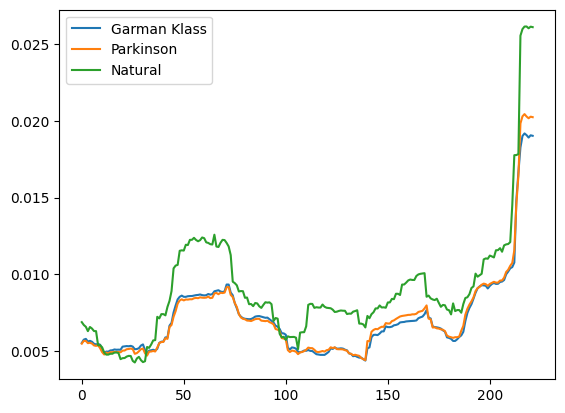

In [229]:

plt.plot(sigma_gk, label='Garman Klass')
plt.plot(sigma_p, label='Parkinson')
plt.plot(nat_sigma, label='Natural')
#plt.plot(data_vix.Close/10000, label='VIX')
plt.legend()
plt.show()

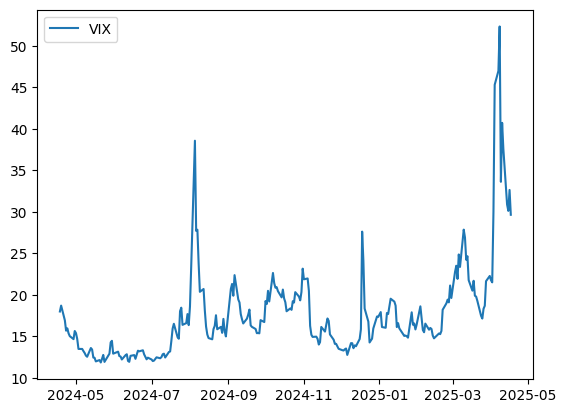

In [230]:
plt.plot(data_vix.Close, label='VIX')
plt.legend()
plt.show()

Now we perform statistical analyses to assess the relationship between the time series

In [235]:
len(sigma_gk), len(sigma_p), len(np.ravel(data_vix.Close)[29:])

(222, 222, 222)

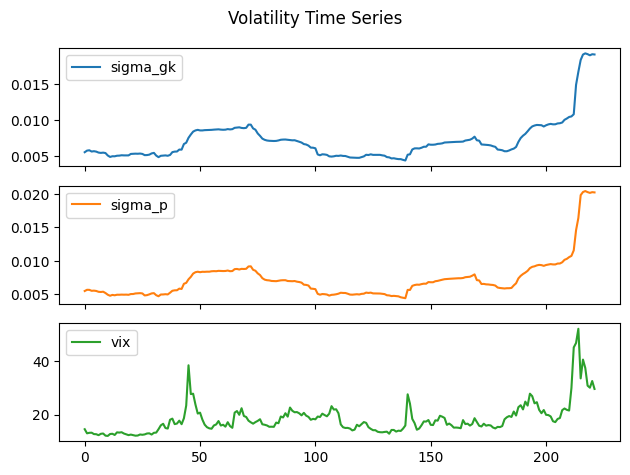

In [237]:
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, ccf
from statsmodels.api import OLS, add_constant
from scipy.stats import pearsonr, spearmanr
vix_path = np.ravel(data_vix.Close)[29:]
time_series_data = pd.DataFrame({
    'sigma_gk': sigma_gk,
    'sigma_p': sigma_p,
    'sigma_nat': nat_sigma,
    'vix': vix_path
})
time_series_data.plot(subplots=True, title="Volatility Time Series")
plt.tight_layout()
plt.show()

In [238]:
print("Pearson Correlation:\n", time_series_data.corr(method='pearson'))
print("\nSpearman Correlation:\n", time_series_data.corr(method='spearman'))


Pearson Correlation:
            sigma_gk   sigma_p  sigma_nat       vix
sigma_gk   1.000000  0.996212   0.955462  0.726856
sigma_p    0.996212  1.000000   0.963756  0.723949
sigma_nat  0.955462  0.963756   1.000000  0.688750
vix        0.726856  0.723949   0.688750  1.000000

Spearman Correlation:
            sigma_gk   sigma_p  sigma_nat       vix
sigma_gk   1.000000  0.982987   0.859973  0.606938
sigma_p    0.982987  1.000000   0.908121  0.621646
sigma_nat  0.859973  0.908121   1.000000  0.551025
vix        0.606938  0.621646   0.551025  1.000000


C:\Users\andre\AppData\Local\Temp\ipykernel_22920\3269969347.py:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print("Pearson Correlation:\n", time_series_data.corr(method='pearson'))
C:\Users\andre\AppData\Local\Temp\ipykernel_22920\3269969347.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print("\nSpearman Correlation:\n", time_series_data.corr(method='spearman'))


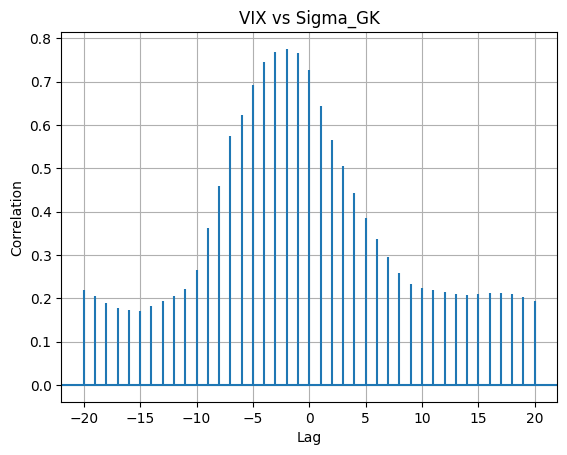

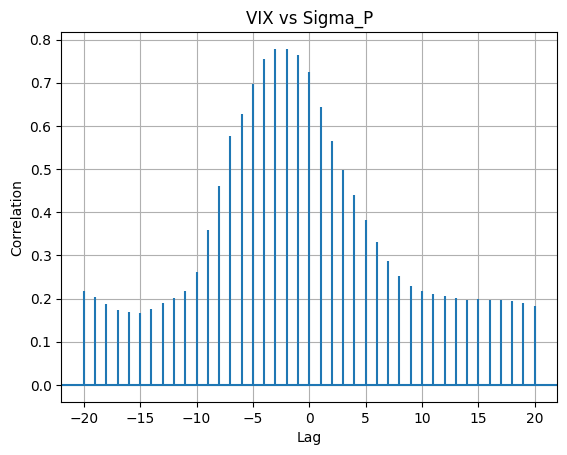

In [239]:
# Cross-correlation between VIX and sigma_gk/p
def plot_ccf(x, y, lags=20, title="Cross-Correlation"):
    plt.xcorr(x - np.mean(x), y - np.mean(y), maxlags=lags)
    plt.title(title)
    plt.xlabel("Lag")
    plt.ylabel("Correlation")
    plt.grid(True)
    plt.show()

plot_ccf(time_series_data['vix'], time_series_data['sigma_gk'], title='VIX vs Sigma_GK')
plot_ccf(time_series_data['vix'], time_series_data['sigma_p'], title='VIX vs Sigma_P')


In [245]:
# Simple linear regression
X = add_constant(time_series_data[['sigma_p']]) # the one correlated the most with VIX, also to avoid multicolinearity
y = time_series_data['vix']
model = OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                    vix   R-squared:                       0.524
Model:                            OLS   Adj. R-squared:                  0.522
Method:                 Least Squares   F-statistic:                     242.3
Date:                Fri, 18 Apr 2025   Prob (F-statistic):           2.48e-37
Time:                        09:37:45   Log-Likelihood:                -628.24
No. Observations:                 222   AIC:                             1260.
Df Residuals:                     220   BIC:                             1267.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.7909      0.727     10.720      0.0

In [244]:
for col in time_series_data.columns:
    result = adfuller(time_series_data[col])
    print(f"\nADF Test for {col}:")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")



ADF Test for sigma_gk:
ADF Statistic: 0.1461
p-value: 0.9691

ADF Test for sigma_p:
ADF Statistic: 0.5106
p-value: 0.9852

ADF Test for sigma_nat:
ADF Statistic: -0.0443
p-value: 0.9547

ADF Test for vix:
ADF Statistic: -3.3647
p-value: 0.0122


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\_asarray.py:126: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  arr = array(a, dtype=dtype, order=order, copy=False, subok=subok)


In [246]:
from statsmodels.tsa.stattools import grangercausalitytests
grangercausalitytests(time_series_data[['vix', 'sigma_p']], maxlag=2, verbose=True)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3156  , p=0.1295  , df_denom=218, df_num=1
ssr based chi2 test:   chi2=2.3474  , p=0.1255  , df=1
likelihood ratio test: chi2=2.3350  , p=0.1265  , df=1
parameter F test:         F=2.3156  , p=0.1295  , df_denom=218, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.7103  , p=0.0260  , df_denom=215, df_num=2
ssr based chi2 test:   chi2=7.5933  , p=0.0224  , df=2
likelihood ratio test: chi2=7.4652  , p=0.0239  , df=2
parameter F test:         F=3.7103  , p=0.0260  , df_denom=215, df_num=2


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


{1: ({'ssr_ftest': (2.315551811720504, 0.12953500063027065, 218.0, 1),
   'ssr_chi2test': (2.3474172036249144, 0.1254907713115967, 1),
   'lrtest': (2.3350378919687955, 0.12649191246077177, 1),
   'params_ftest': (2.3155518117204417, 0.12953500063027604, 218.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (3.710340408747424, 0.02604978366617219, 215.0, 2),
   'ssr_chi2test': (7.5932547899947265, 0.0224463470041661, 2),
   'lrtest': (7.465154226821596, 0.023931083183684032, 2),
   'params_ftest': (3.7103404087474545, 0.02604978366617169, 215.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])])}

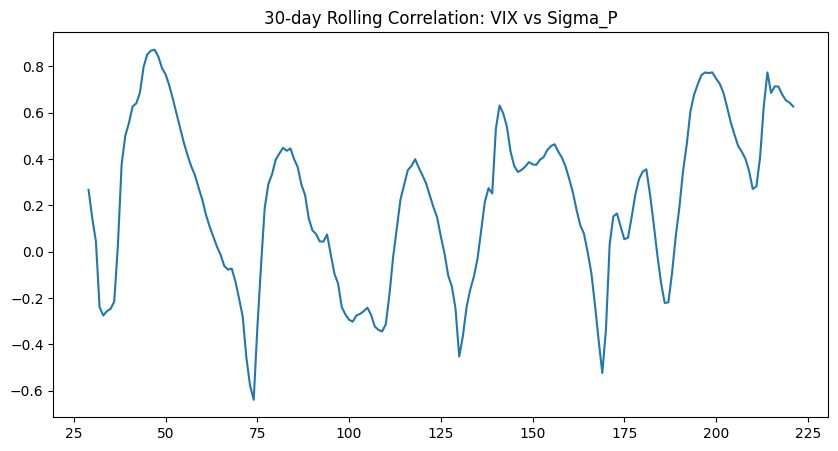

In [248]:
rolling_corr = time_series_data['vix'].rolling(30).corr(time_series_data['sigma_p'])
rolling_corr.plot(title='30-day Rolling Correlation: VIX vs Sigma_P', figsize=(10, 5))
plt.show()


In [249]:
spx_data.head()

Price,Close,High,Low,Open,Volume
Ticker,^SPX,^SPX,^SPX,^SPX,^SPX
Date,,,,,
2024-04-18,5011.120117,5056.660156,5001.890137,5031.520020,3619760000
2024-04-19,4967.229980,5019.020020,4953.560059,5005.439941,3878750000
2024-04-22,5010.600098,5038.839844,4969.399902,4987.330078,3820250000
2024-04-23,5070.549805,5076.120117,5027.959961,5028.850098,3751400000
2024-04-24,5071.629883,5089.479980,5047.020020,5084.859863,3656740000


In [250]:
spx_data['returns'] = spx_data['Close'].pct_change().dropna()

# Align everything on date
returns_df = pd.DataFrame({
    'returns': np.ravel(spx_data['returns'][29:]),
    'vix': np.ravel(data_vix['Close'][29:]),
    'sigma_gk': sigma_gk,
    'sigma_p': sigma_p
}).dropna()



In [251]:
len(spx_data['returns'][29:]),len(data_vix['Close'][29:]), len(sigma_gk)

(222, 222, 222)

In [252]:
print(returns_df.shape)
print(returns_df[['returns', 'vix']].dropna().shape)
print(returns_df[['returns', 'vix']].isna().sum())

(222, 4)
(222, 2)
returns    0
vix        0
dtype: int64


In [253]:
from statsmodels.api import OLS, add_constant

X_vix = add_constant(returns_df['vix'])
model_vix = OLS(returns_df['returns'], X_vix).fit()
print(model_vix.summary())


                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     18.63
Date:                Fri, 18 Apr 2025   Prob (F-statistic):           2.40e-05
Time:                        09:38:41   Log-Likelihood:                 667.39
No. Observations:                 222   AIC:                            -1331.
Df Residuals:                     220   BIC:                            -1324.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0108      0.003      4.138      0.0

In [255]:
X_sigma = add_constant(returns_df['sigma_p'])
model_sigma = OLS(returns_df['returns'], X_sigma).fit()
print(model_sigma.summary())


                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.1421
Date:                Fri, 18 Apr 2025   Prob (F-statistic):              0.707
Time:                        09:38:53   Log-Likelihood:                 658.44
No. Observations:                 222   AIC:                            -1313.
Df Residuals:                     220   BIC:                            -1306.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.002     -0.308      0.7

We observe statistically significant (p = Prob(Omnibus test) < 0.01) negative relationship between SPX returns and VIX, given that the equation is:

$$ RETURNS = ALPHA + BETA * VIX $$

The fact that $R^2$ is low means that VIX here explains only a small fraction of the return variation, which is expected for daily returns. VIX normally serves as a fear measurement, and tends to rise when the market falls.

In [256]:
alpha = model_vix.params[0]
beta = model_vix.params[1]
print(f"alpha: {alpha}") # intercept
print(f"beta: {beta}")

alpha: 0.010789336748923992
beta: -0.0005861197232981541


C:\Users\andre\AppData\Local\Temp\ipykernel_22920\2209425388.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = model_vix.params[0]
C:\Users\andre\AppData\Local\Temp\ipykernel_22920\2209425388.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model_vix.params[1]


On the other hand, the relationship between SPX returns vs Realized vol is not statistically significant (p > 0.7). The takeaway is that the realized volatility does not explain daily SPX returns meaningfully, and this aligns with the fact that volatility is more of a risk gauge than a return predictor

## 3) Hedging: Volatility Mismatch

In [94]:
from scipy.stats import norm

def euler_scheme(S0, r, sigma, T, n=1000):
    dt = T / n
    S = np.zeros(n + 1)
    S[0] = S0
    for i in range(1, n + 1):
        dW = np.random.normal(0, np.sqrt(dt))
        S[i] = S[i - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * dW)
    return S

def calculate_delta(S, K, T, t, r, sigma):
    if sigma <= 0:
        raise ValueError("sigma must be positive")
    if T - t <= 0:
        raise ValueError("T - t must be positive")
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * (T - t)) / (sigma * np.sqrt(T - t))
    return norm.cdf(d1)

def call_option_payoff(S, K):
    return np.maximum(S - K, 0)

In [95]:
def dynamic_hedging(S, K, T, r, sigma, dt, n=1000, k=252):
    """
    Simulate dynamic hedging strategy and return hedging error
    Parameters:
        S: list of stock prices
        K: strike price
        T: expiration date
        r: risk-free rate
        sigma: volatility
        n: number of time steps for stock simulation
        k: number of hedgings
    """
    cash = 0
    shares = calculate_delta(S[0], K, T, 0, r, sigma)
    cash = S0 * shares  # cost to buy shares (you are short the option)
    cash = -cash  # you pay this

    # Dynamic hedging
    n_of_hedgings = 0
    for i in range(1, n):
        t = i * dt
        if m.isclose(t, k * dt, abs_tol=k / (2*n)): 
            new_delta = calculate_delta(S[i], K, T, t, r, sigma)
            delta_change = new_delta - shares
            cash -= delta_change * S[i]  # pay for buying/selling stock
            cash *= np.exp(r * dt)  # interest earned on cash
            shares = new_delta  # update stock position
            n_of_hedgings += 1

    # At maturity
    cash += shares * S[-1]  # sell remaining shares
    hedging_error = cash - call_option_payoff(S[-1], K)

    return hedging_error, n_of_hedgings


In [96]:
# Parameters
K = 99
S0 = 100
r = 0.06
sigma = 0.2
T = 1
n = 1000  # simulation points
k = 252 # number of hedgings
dt = T / n

S = euler_scheme(S0, r, sigma, T, n)

# Simulate hedging strategy
n = 1000
k = 52
hedging_error, n_of_hedgings = dynamic_hedging(S, K, T, r, sigma, dt, n, k)


print(f"Final hedging error: {hedging_error:.4f}")
print(f"Number of hedgings: {n_of_hedgings}")

Final hedging error: -2.4821
Number of hedgings: 52


In [97]:
# Parameters
K = 99
S0 = 100
r = 0.06
sigma = 0.2
T = 1
n = 1000  # simulation points
k = 252 # number of hedgings
dt = T / n

hedging_errors = {252: [], 52: [], 12: []}

for k in hedging_errors.keys():
    for _ in range(1000):
        S = euler_scheme(S0, r, sigma, T, n)
        hedging_error, n_of_hedgings = dynamic_hedging(S, K, T, r, sigma, dt, n, k)
        hedging_errors[k].append(hedging_error)

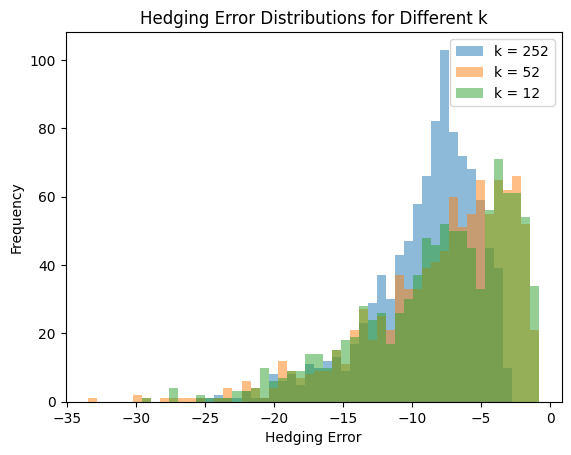

In [98]:
all_errors = []
for k in [252, 52, 12]:
    all_errors.extend(hedging_errors[k])

# Define consistent bins
min_err = min(all_errors)
max_err = max(all_errors)
bins = np.linspace(min_err, max_err, 51)  # 50 bins

# Plot
for k in [252, 52, 12]:
    plt.hist(hedging_errors[k], bins=bins, alpha=0.5, label=f"k = {k}", density=False)  # Optional: density
plt.xlabel("Hedging Error")
plt.ylabel("Frequency")
plt.legend()
plt.title("Hedging Error Distributions for Different k")
plt.show()

### Mismatched Volatility

In [99]:
# Parameters
K = 99
S0 = 100
r = 0.06
sigma = 0.2
T = 1
n = 1000  # simulation points
k = 252 # number of hedgings
dt = T / n

vols = [0.10, 0.15, 0.25, 0.30]

hedging_errors = {str(vol): {252: [], 52: [], 12: []} for vol in vols}

for vol in vols:
    for k in hedging_errors[str(vol)].keys():
        for _ in range(1000):
            S = euler_scheme(S0, r, vol, T, n)
            # We use a different vol for hedging: sigma = 0.2
            hedging_error, n_of_hedgings = dynamic_hedging(S, K, T, r, sigma, dt, n, k)
            hedging_errors[str(vol)][k].append(hedging_error)

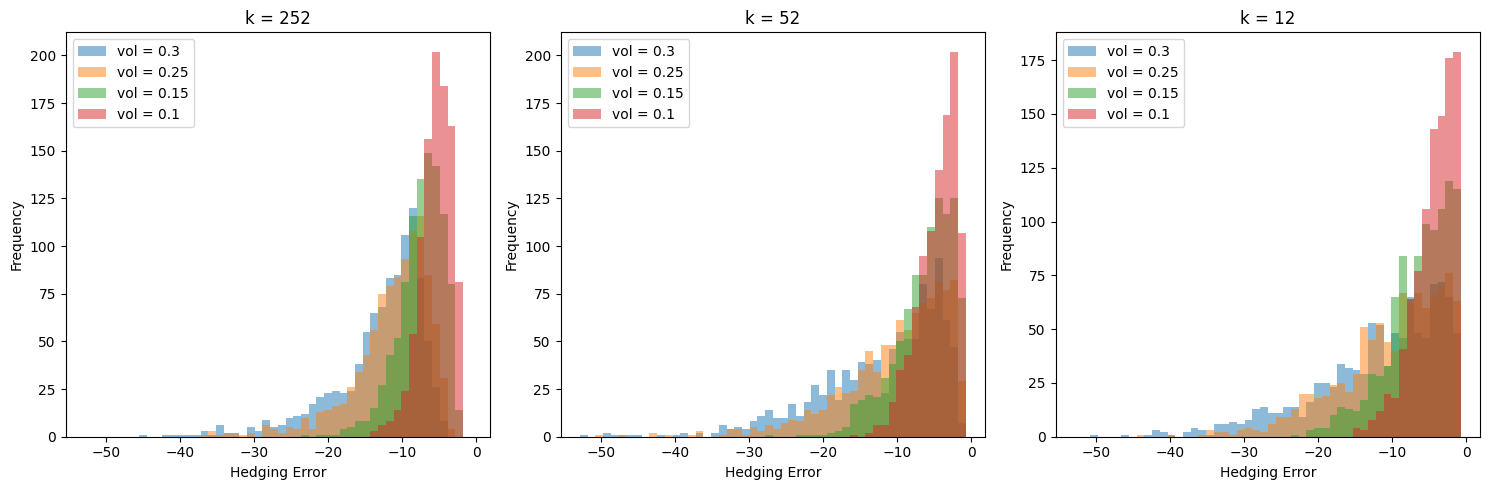

In [100]:
# Collect all errors into a single list to find global min and max
all_errors = []
for vol_errors in hedging_errors.values():
    for k_errors in vol_errors.values():
        all_errors.extend(k_errors)

min_err = min(all_errors)
max_err = max(all_errors)
bins = np.linspace(min_err, max_err, 51)  # 50 bins

plt.figure(figsize=(15, 5))
for i, k in enumerate([252, 52, 12]):
    plt.subplot(1, 3, i + 1)
    for vol in reversed(vols):
        plt.hist(hedging_errors[str(vol)][k], bins=bins, alpha=0.5,
                 label=f"vol = {vol}", density=False)  # Optional: density=True
    plt.title(f"k = {k}")
    plt.xlabel("Hedging Error")
    plt.ylabel("Frequency")
    plt.legend()
plt.tight_layout()
plt.show()